Dataset

In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')
df.head(10)

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369
5,190,3.0,NaN,2484.883986,14.7,2008,Europe,Gasoline,All-wheel drive,-1.0,17.271818
6,240,7.0,127.0,3006.542287,22.2,2012,USA,Gasoline,Front-wheel drive,1.0,13.210412
7,150,4.0,239.0,3638.657780,17.3,2020,USA,Diesel,All-wheel drive,1.0,12.848884
8,250,1.0,174.0,2714.219310,10.3,2016,Asia,Diesel,Front-wheel drive,-1.0,16.823554
9,150,4.0,123.0,3509.036569,10.2,2005,USA,Gasoline,Front-wheel drive,-1.0,12.298355


In [104]:
base = ['engine_displacement','horsepower','vehicle_weight','model_year']
df[base].head(5)


,engine_displacement,horsepower,vehicle_weight,model_year
0,170,159.0,3413.433759,2003
1,130,97.0,3149.664934,2007
2,170,78.0,3079.038997,2018
3,220,NaN,2542.392402,2009
4,210,140.0,3460.870990,2009


Exploratory Data Analysis

In [105]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

engine_displacement
[170 130 220 210 190]
36

num_cylinders
[ 3.  5. nan  4.  1.]
14

horsepower
[159.  97.  78.  nan 140.]
192

vehicle_weight
[3413.43375861 3149.66493422 3079.03899737 2542.39240183 3460.87098999]
9704

acceleration
[17.7 17.8 15.1 20.2 14.4]
162

model_year
[2003 2007 2018 2009 2008]
24

origin
['Europe' 'USA' 'Asia']
3

fuel_type
['Gasoline' 'Diesel']
2

drivetrain
['All-wheel drive' 'Front-wheel drive']
2

num_doors
[ 0.  2. -1.  1. nan]
9

fuel_efficiency_mpg
[13.23172891 13.68821744 14.246341   16.9127356  12.48836912]
9704



<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

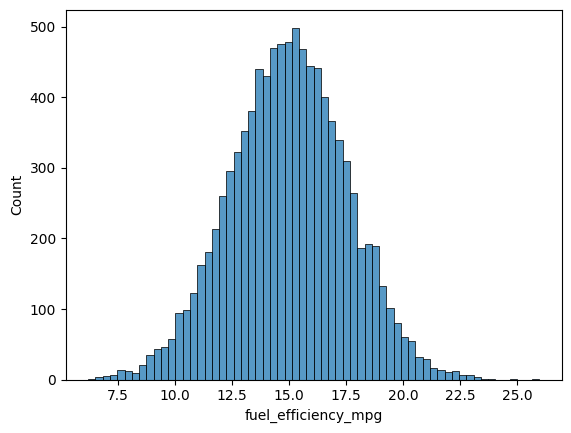

In [106]:
sns.histplot(df['fuel_efficiency_mpg'])

Missing values

In [107]:
df[base].isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
dtype: int64

median (50% percentile) for variable 'horsepower'

In [108]:
horsepower_median = df['horsepower'].median()
horsepower_median

np.float64(149.0)

Prepare and split the dataset

In [109]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)   
n_train = n - n_val - n_test
n, n_val, n_test, n_train

(9704, 1940, 1940, 5824)

In [110]:
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

In [111]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]


In [112]:
# Features
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [113]:
# Target
y_train = df_train['fuel_efficiency_mpg'].values
y_val = df_val['fuel_efficiency_mpg'].values
y_test = df_test['fuel_efficiency_mpg'].values

In [114]:
# Drop the target before training
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

Train a linear regression model without regularization

In [115]:
# Function to return weights
# w = inv (transposeX * X) * transposeX * y
# transposeX is written as X.T

def get_weights(X,y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]  # return intercept and weights
    


In [116]:
# Train the model using 0 for NaN values in horsepower

X_train_0 = df_train[base].fillna(0).values
w0_0, w_0 = get_weights(X_train_0, y_train)
y_pred_case1 = w0_0 + X_train_0.dot(w_0)
y_pred_case1[:10]

array([17.33526223, 16.29296317, 17.69885099, 11.47249885, 19.23145943,
       12.15660811, 11.80853407, 17.41522511, 16.26583007, 14.00894032])

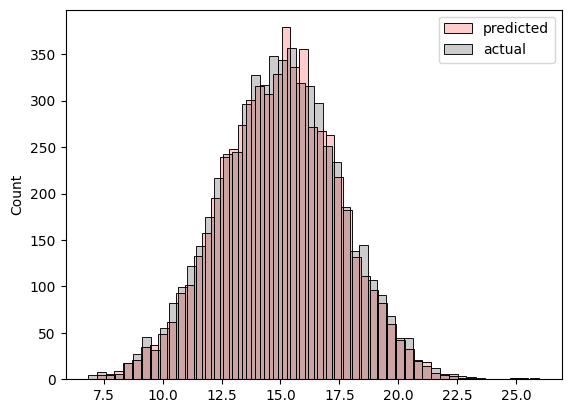

In [117]:
sns.histplot(y_pred_case1, color='red', label='predicted', alpha=0.2)
sns.histplot(y_train, color='black', label='actual', alpha=0.2)
plt.legend()

In [118]:
# Train the model using mean for NaN values in horsepower
mean_hp = df_train['horsepower'].mean()
X_train_mean = df_train[base].copy()
X_train_mean['horsepower'] = X_train_mean['horsepower'].fillna(mean_hp)
w0_mean, w_mean = get_weights(X_train_mean, y_train)
y_pred_case2 = w0_mean + X_train_mean.dot(w_mean)
y_pred_case2[:10]

0    17.259110
1    16.190113
2    17.692459
3    11.814410
4    18.934381
5    11.918260
6    11.554643
7    17.389881
8    16.236402
9    13.949490
dtype: float64

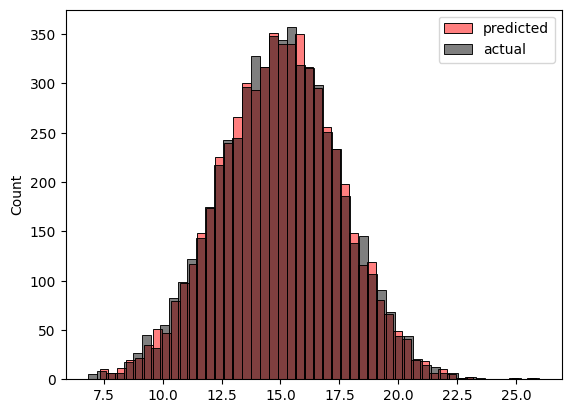

In [119]:
sns.histplot(y_pred_case2, color='red', label='predicted', alpha=0.5)
sns.histplot(y_train, color='black', label='actual', alpha=0.5)
plt.legend()

In [120]:
# RMSE
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

np.round(rmse(y_train, y_pred_case1),2), np.round(rmse(y_train, y_pred_case2),2)

(np.float64(0.52), np.float64(0.46))

In [121]:
# Validate the model using 0 for NaN values in horsepower on validation set
X_val_0 = df_val[base].fillna(0).values
y_pred_val_0 = w0_0 + X_val_0.dot(w_0)
score = np.round(rmse(y_val, y_pred_val_0),2)
score

np.float64(0.52)

In [122]:
# Validate the model using mean for NaN values in horsepower on validation set
X_val_mean = df_val[base].copy()
X_val_mean['horsepower'] = X_val_mean['horsepower'].fillna(mean_hp)
y_pred_val_mean = w0_mean + X_val_mean.dot(w_mean)
score = np.round(rmse(y_val, y_pred_val_mean),2)
score

np.float64(0.46)

Add features and train


In [123]:
df['model_year'].max()

np.int64(2023)

In [124]:
def prepare_features(df):
    df = df.copy()
    df['age'] = 2023 - df['model_year']
    features = ['engine_displacement','horsepower','vehicle_weight','age']
    df_num=df[features]
    df_num=df_num.fillna(0)
    X = df_num.values
    return X

In [125]:
X_train = prepare_features(df_train)
w0, w = get_weights(X_train, y_train)
X_val = prepare_features(df_val)
y_pred_val_age = w0 + X_val.dot(w)
score=np.round(rmse(y_val, y_pred_val_age),2)
score

np.float64(0.52)

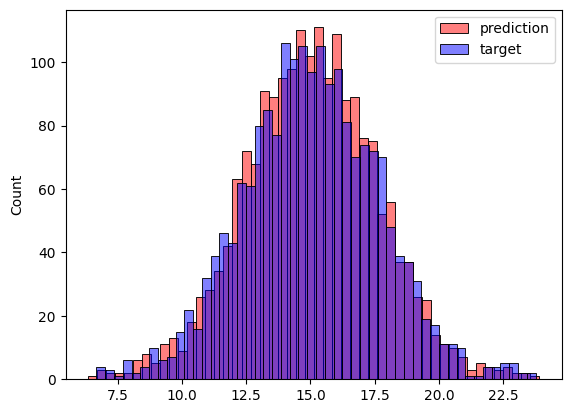

In [126]:
sns.histplot(y_pred_val_age, label='prediction', color='red', alpha=0.5, bins=50)
sns.histplot(y_val, label='target', color='blue',  alpha=0.5, bins=50)
plt.legend()

Add categorical variables

In [127]:
df['num_doors'].value_counts()

num_doors
 0.0    3551
 1.0    2192
-1.0    2183
-2.0     594
 2.0     563
 3.0      58
-3.0      56
-4.0       4
 4.0       1
Name: count, dtype: int64

In [ ]:
# Make num_doors positive, replace 0 and NaN with 1

df['num_doors'] = df['num_doors'].abs().replace({0:1}).fillna(1)
df['num_doors'].value_counts()

num_doors
1.0    8428
2.0    1157
3.0     114
4.0       5
Name: count, dtype: int64

In [129]:
categorical_variables = ['origin','fuel_type', 'drivetrain']

categorical = {}

for c in categorical_variables:
    categorical[c] = list(df_train[c].value_counts().head().index)

categorical

{'origin': ['Asia', 'Europe', 'USA'],
 'fuel_type': ['Gasoline', 'Diesel'],
 'drivetrain': ['All-wheel drive', 'Front-wheel drive']}

In [130]:
def prepare_features(df):
    
    df = df.copy()
    features = base.copy()
    df['horsepower'] = df['horsepower'].fillna(0)
    df['age'] = 2023 - df['model_year']
    features.append('age')

    for v in [1, 2]:
        df['num_doors_%d' % v] = (df.num_doors == v).astype(int)
        features.append('num_doors_%d' % v)
    
    for name, values in categorical.items():
        for value in values:
            df['%s_%s' % (name, value)] = (df[name] == value).astype(int)
            features.append('%s_%s' % (name, value))

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    
    return X


In [131]:
X_train = prepare_features(df_train)

w0, w = get_weights(X_train, y_train)

X_val = prepare_features(df_val)
y_pred_features = w0 + X_val.dot(w)
score = np.round(rmse(y_val, y_pred_features),2)
score


np.float64(126.04)

Train a linear regression model with regularization

In [132]:

def get_weights_reg(X,y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]  # return intercept and weights
    

In [133]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = prepare_features(df_train)
    w0, w = get_weights_reg(X_train, y_train, r=r)

    X_val = prepare_features(df_val)
    y_pred_features = w0 + X_val.dot(w)
    rmse_num = rmse(y_val, y_pred_features)
    score = np.round(rmse_num,2)
    print(r,w0,rmse_num,score)

0 -3.69005998296362e+16 126.03922811099639 126.04
0.01 1.424422149809134e-05 0.5173145297638299 0.52
0.1 1.4242096631702054e-05 0.5173144409459426 0.52
1 1.42413285085718e-05 0.5173135572262422 0.52
5 1.4241403437607076e-05 0.5173097270073079 0.52
10 1.4241486872654067e-05 0.5173051535881646 0.52
100 1.4242186891348362e-05 0.5172510255760534 0.52


Seed

In [134]:
rmse_scores = []

for seed in range(10):
    n = len(df)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
    df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

    y_train = df_train['fuel_efficiency_mpg'].values
    y_val = df_val['fuel_efficiency_mpg'].values

    X_train = df_train[base].fillna(0).values
    X_val = df_val[base].fillna(0).values

    w0, w = get_weights(X_train, y_train)
    y_pred_val = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred_val)
    rmse_scores.append(score)

std = np.std(rmse_scores)
print("Standard deviation of RMSE scores:", round(std, 3))

Standard deviation of RMSE scores: 0.007


In [135]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

y_train = df_train['fuel_efficiency_mpg'].values
y_val = df_val['fuel_efficiency_mpg'].values
y_test = df_test['fuel_efficiency_mpg'].values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)


X_full_train = prepare_features(df_full_train)
y_full_train = np.concatenate([y_train, y_val])

w0, w = get_weights_reg(X_full_train, y_full_train, r=0.001)
X_test = prepare_features(df_test)
y_pred = w0 + X_test.dot(w)
print(np.round(rmse(y_test, y_pred),2))

0.52
